In [1]:
from __future__ import division,print_function

import os
import sys

from configparser import ConfigParser                  ### For parsing the configuration file
import h5py
import healpy as hp
import pandas as pd
import matplotlib as mpl             ### For plotting options
import matplotlib.pyplot as plt
import numpy as np
import pprint
import time
import pickle
from scipy.interpolate import interp1d

galacticus_folder=os.environ["GALACTICUS_EXEC_PATH"]
DARK_MATTER_DATA_LOCATION=os.environ["DARK_MATTER_DATA_LOCATION"]
DARK_MATTER_PAPER_LOCATION=os.environ["DARK_MATTER_PAPER_LOCATION"]
DARK_MATTER_CODE_LOCATION = os.environ["DARK_MATTER_CODE_LOCATION"]
sys.path.insert(0, DARK_MATTER_CODE_LOCATION)


import distribution_functions as dist
import model_utils
import sterile_neutrinos as sn
import plot_utils
import strong_lensing_data_processing as sl
import thermal_relic as th
import transfer_functions



## Parsing the posterior from Gilman et al. 2020
https://arxiv.org/pdf/1908.06983.pdf

Upper 95% upper limit on m is 8.087381230205034
Lower 95% lower limit on m is 4.980730121686948
Upper 95% upper limit on m is 122287325.40259938
Lower 95% lower limit on m is 95659.99150000757


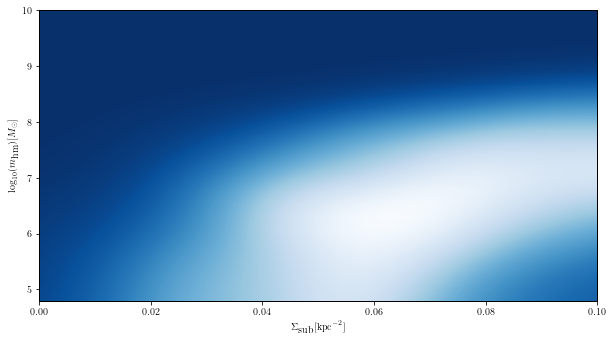

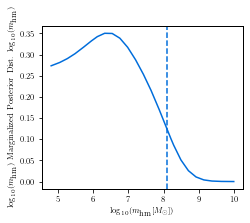

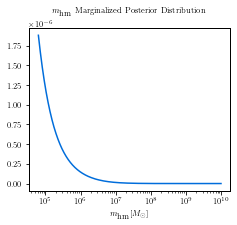

In [2]:
### Load the likelihood, which is provided as a 2D python function that has been pickled
f = sl.load_posterior(paper = "Gilman2020")
### Marginalize the likelihood to obtain the posterior distribution for log10(mhm)
log10_m_hm, p_log10_mhm = sl. marginalizing_over_sigma(f, samples=3000)
sl.plot_m_hm_posterior(log10_m_hm,p_log10_mhm)
### Transform the p(log10(mhm)) to p(mhm)
m_hm, p_m_hm = sl.mhm_log_to_linear(log10_m_hm,p_log10_mhm)


#### Test: Check that the 95 limit of p(log10mhm) and p(mhm) give the same number 

In [3]:
 
lower_95_log10mhm, upper_95_log10mhm, p = dist.norm_and_limit(log10_m_hm, p_log10_mhm )

Upper 95% upper limit on m is 8.087381230205034
Lower 95% lower limit on m is 4.980730121686948


In [4]:
lower_95_mhm, upper_95_mhm, p = dist.norm_and_limit(m_hm, p_m_hm  )

Upper 95% upper limit on m is 122287325.40259938
Lower 95% lower limit on m is 95659.99150000757


In [5]:
### taking the log of the lower 95% limit of m_hm
np.log10(upper_95_mhm)

8.087381446464235

In [6]:
## yep, they are the same.

#### Note: these numbers, 8.08 instead of 7.8, are slightly different than the ones in Gilman2020, because there they resample the likelihood and bin it in 20 bins. We chose to no resample and use the directly the kernel smoothed likelihood that was calculated from the multiplied likelihoods for each quasar

## Calculating Thermal Relic WDM

Thermal relic WDM, for case  Case I   include_baryons
Upper 95% upper limit on m is 39.79896227240268
Lower 95% lower limit on m is 4.641765367040939
Thermal relic WDM, for case  Case II   no_baryons
Upper 95% upper limit on m is 37.106684538073026
Lower 95% lower limit on m is 4.327764176252796


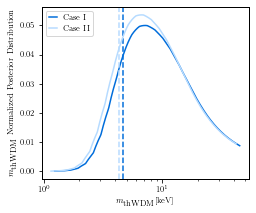

In [7]:
th.plot_thWDM(m_hm,p_m_hm)

## Sterile Neutrino PK and KTY cases

In [ ]:
#### Kev 2022 February Transfer functions
t1 = transfer_functions.TransferFunctions(cosmo_constants_type="Planck2018", transfer_function_type = "PK",th_WDM_model_type="viel")
t1.fit_sn_with_WDM(paper_plot=False)
poly_dict_thWDM_to_sn, poly_dict_sn_to_thWDM =t1.fit_polynomials()

#### KTY Transfer functions
t2 = transfer_functions.TransferFunctions(cosmo_constants_type="Planck2018", transfer_function_type = "KTY",th_WDM_model_type="viel")
t2.fit_sn_with_WDM(paper_plot=False)


#### Make the fit tables
transfer_functions.make_table(t1,t2)
### Make the plots of m_sn vs m_thWDM
transfer_functions.plot_sn_vs_wdm_overlay(t1, t2, paper_plot=True)

In [ ]:
# poly_dict_thWDM_to_sn1, poly_dict_sn_to_thWDM1 =t.fit_polynomials()

# run_sn_all_cases(m_hm,p_m_hm,poly_dict_thWDM_to_sn1)
sn.plot_sn_posteriors(m_hm,p_m_hm,t1,t2)

In [ ]:
color_dict =plot_utils.colorblind_color_dict_15()
color_dict

### Dodelson Wilson

In [ ]:
sn.calculate_DW(m_hm,p_m_hm)

In [ ]:


sn.plot_all_sn(m_hm,p_m_hm,t1,t2)

In [ ]:
sn.plot_all_sn_panels(m_hm,p_m_hm,t1,t2)

In [ ]:
##from Vegetti et al 2018 https://ui.adsabs.harvard.edu/abs/2018MNRAS.481.3661V
#95% upper and lower limits for log(M_hm) M_sun: 9.16, 11.91 
#68%  upper and lower limits for log(M_hm) M_sun: 6.43, 12.01

## Lyman-alpha limit

In [ ]:
#These are limits based on the lyman-alpha paper: 

### 3.3 keV constraint from Viel et al. (2013), 5.3 keV constraint from Iršič et al. (2017)
m_thWDM_lalpha_viel = 3.3 #keV
m_thWDM_lalpha_irsic = 5.3 #keV


In [ ]:
### Limits on PK and KTY
def lyman_alpha_PK_and_KTY(degree=2):
    poly_dict_thWDM_to_snPK, poly_dict_sn_to_thWDM1 =t1.fit_polynomials()
    poly_dict_thWDM_to_snKTY, poly_dict_sn_to_thWDM1 =t2.fit_polynomials()
    m_snPK_v = sn.m_sn_from_m_thWDM(poly_dict_thWDM_to_snPK, np.array([m_thWDM_lalpha_viel]), degree)
    m_snPK_i = sn.m_sn_from_m_thWDM(poly_dict_thWDM_to_snPK, np.array([m_thWDM_lalpha_irsic]), degree)
    print( "PK SnDW Ly alpha: Viel", m_snPK_v,"keV, Irsic", m_snPK_i, "keV")
    m_snKTY_v = sn.m_sn_from_m_thWDM(poly_dict_thWDM_to_snKTY, np.array([m_thWDM_lalpha_viel]), degree)
    m_snKTY_i = sn.m_sn_from_m_thWDM(poly_dict_thWDM_to_snKTY, np.array([m_thWDM_lalpha_irsic]), degree)
    print( "KTY SnDW Ly alpha: Viel", m_snKTY_v,"keV, Irsic", m_snKTY_i, "keV")
    
        
lyman_alpha_PK_and_KTY(degree=2)

In [ ]:
### Limits on DW

def get_Omega_DM():
    H_0, Omega_Baryon, Omega_Matter, Omega_Lambda, Omega_Neutrinos, T_cmb, h = model_utils.cosmo_param_Planck_2018()
    Omega_DM = Omega_Matter-Omega_Baryon-Omega_Neutrinos
    return Omega_DM
def lyman_alpa_DW():
    Omega_DM = get_Omega_DM()
    msnDW_v = sn.m_thWDM_to_msnDW(m_thWDM_lalpha_viel, Omega_DM)
    msnDW_i = sn.m_thWDM_to_msnDW(m_thWDM_lalpha_irsic, Omega_DM)
    print("SnDW Ly alpha: Viel", msnDW_v,"keV, Irsic", msnDW_i, "keV")
    return msnDW_v, msnDW_i
lyman_alpa_DW()

In [ ]:
### Limits on nuMSM

def hm_from_thWDM():
    
    case_list = ["include_baryons","no_baryons" ]
    label_list= ["Case I","Case II"]
    m_sn_list = []
    p_sn_list = []
    sn_lower_limit_list = []
    
    for case_index in range(len(case_list)):
        case  = case_list[case_index]
        print("Calculating case", case)

        label=label_list[case_index]
        m_hmv = th.m_thWDM_to_m_hm(m_thWDM_lalpha_viel,case)
        m_hmi = th.m_thWDM_to_m_hm(m_thWDM_lalpha_irsic,case)
        print(np.log10(m_hmv))
        print(np.log10(m_hmi))


In [ ]:
hm_from_thWDM()

## Constraints using Milky Way satellite analysis

In [ ]:

def galaxy_constraints(degree=2):
    m_hm_G = 10**7.0
    
    poly_dict_thWDM_to_snPK, poly_dict_sn_to_thWDM1 =t1.fit_polynomials()
    poly_dict_thWDM_to_snKTY, poly_dict_sn_to_thWDM1 =t2.fit_polynomials()
    
    Omega_DM = get_Omega_DM()

    case_list = ["include_baryons","no_baryons" ]
    label_list= ["Case I","Case II"]
    for i in range(2):
        case= case_list[i]
        m_thWDM = th.m_hm_to_m_thWDM(m_hm_G,case)
        print("Case ",case )
        print("thWDM", m_thWDM)
        m_snPK = sn.m_sn_from_m_thWDM(poly_dict_thWDM_to_snPK, np.array([m_thWDM]), degree)
        print( "PK SnDW galaxy: ", m_snPK, " keV")
        m_snKTY = sn.m_sn_from_m_thWDM(poly_dict_thWDM_to_snKTY, np.array([m_thWDM]), degree)
        print( "KTY SnDW galaxy:", m_snKTY," keV")
        m_snDW = sn.m_thWDM_to_msnDW(m_thWDM, Omega_DM)
        print( "DW SnDW galaxy:", m_snDW," keV")
   


In [ ]:
galaxy_constraints()